# TO DELETE

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Telecom/IMA205/TP-5')
current_directory = os.getcwd()
print(current_directory)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Telecom/IMA205/TP-5


# Alzheimer prediction using gray matter density from T1w MRI

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018

# Preparations

## Importing libraries

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler


## Importing data

### Downloading

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas
    y = data['y'] # classes, 0 for controls and 1 for patients
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS

### Choosing the data we will use

In [4]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


## Visualizing the Atlas of reagions of interest

Using the library nilearn we can also plot the atlas used to define the ROIs:

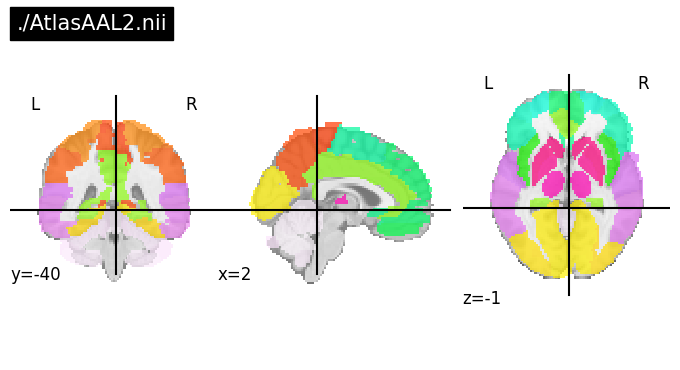

In [5]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

## Splitting train-test

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [6]:
# Create training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(f"nomber of training sample {X_train.shape[0]}, test samples {X_test.shape[0]}")

nomber of training sample 601, test samples 151


## Standarization/Normalization

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used.

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training.

**Answer**

For the case of our data, we already have an array X containing data between 0 and 1 so we don't need to standarize neither normalize the data. In fact, it won't make a sense to do so because we have features that represents the same thing (average density of gray matter in a region) and it is logical to keep the features homogenious and in addition this data was preprocessed by the pipeline described above in [1]. Furthermore, Decision trees are insensitive to scale so this step won't affect the results.

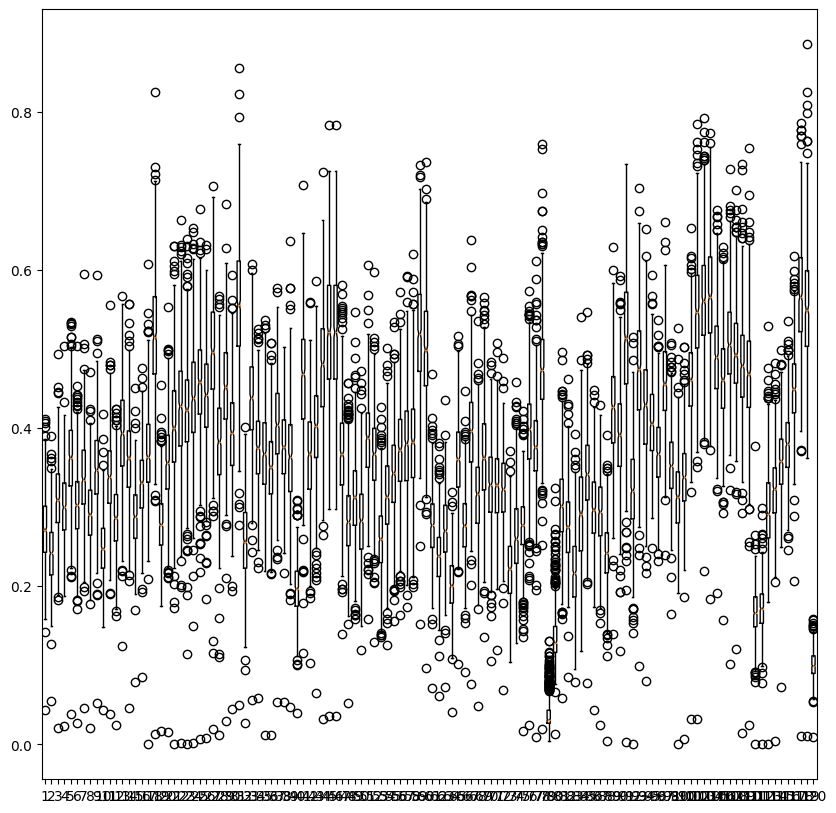

In [7]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
Scaler = MinMaxScaler()
X_train_normalized = Scaler.fit_transform(X_train)
X_test_normalized = Scaler.transform(X_test)



# Model Training

## Decesion Tree with default params

Then, we can fit a Decision tree, with the default setting, using the following code:

In [8]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7814569536423841


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ?


## Decision Tree : testing min_samples_split param

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2


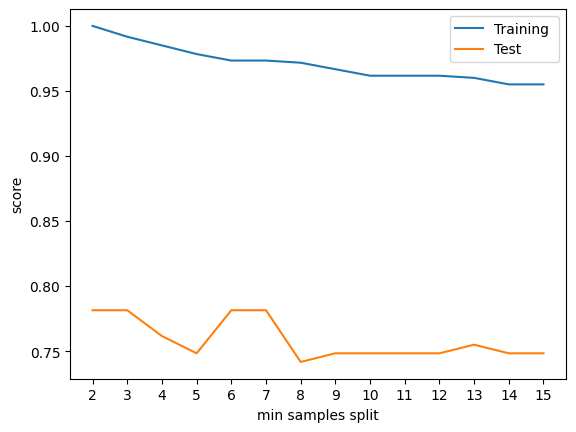

In [9]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training ');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test ');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

## Decision Tree : testing min_samples_leaf param

The best min_samples_leaf value for training is : 1 with score 1.0
The best min_samples_leaf value for testing is : 14 with score 0.8079470198675497


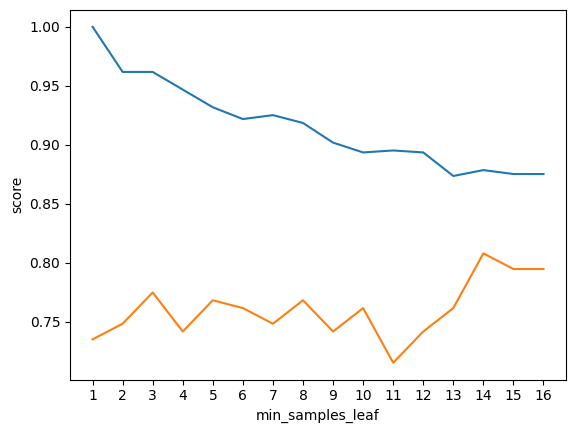

In [10]:
# min_samples_leaf
TTrain =[]
TTest = []
for i in range (1,17):
  Tree = DecisionTreeClassifier(min_samples_leaf = i)
  Tree.fit(X_train,y_train)
  scoreTrain = Tree.score(X_train,y_train)
  scoreTest = Tree.score(X_test,y_test)
  TTrain.append(scoreTrain)
  TTest.append(scoreTest)

plt.plot(TTrain,label="Train")
plt.xticks(np.arange(16), ('1','2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15','16'))
plt.plot(TTest,label="Test")
plt.xlabel("min_samples_leaf")
plt.ylabel("score")

print(f"The best min_samples_leaf value for training is : {np.argmax(TTrain)+1} with score {TTrain[np.argmax(TTrain)]}")

print(f"The best min_samples_leaf value for testing is : {np.argmax(TTest)+1} with score {TTest[np.argmax(TTest)]}")

## Adding noise to the data

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise.

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer**

The results seem instable. We can noitice that when adding noise to the training set of magnitude 0.05 we obtain less accurate results compared to the original data. Further more the results varies with noise. This is due to the nature of the boundary that we get when using decesion trees. These boundaries depends havely on the input data and gives us hard threshholding.

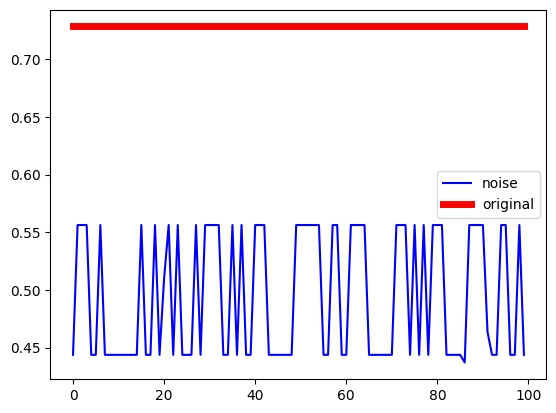

In [11]:

Tree = DecisionTreeClassifier(min_samples_split=15,min_samples_leaf=2,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = np.abs( np.random.normal(0,0.05,X_train_temp[i].shape)) # here we have postive values

    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)

plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*.


# Visualization of the Tree

## Tree without noise

First plot the tree learnt on the original data, witout adding noise.

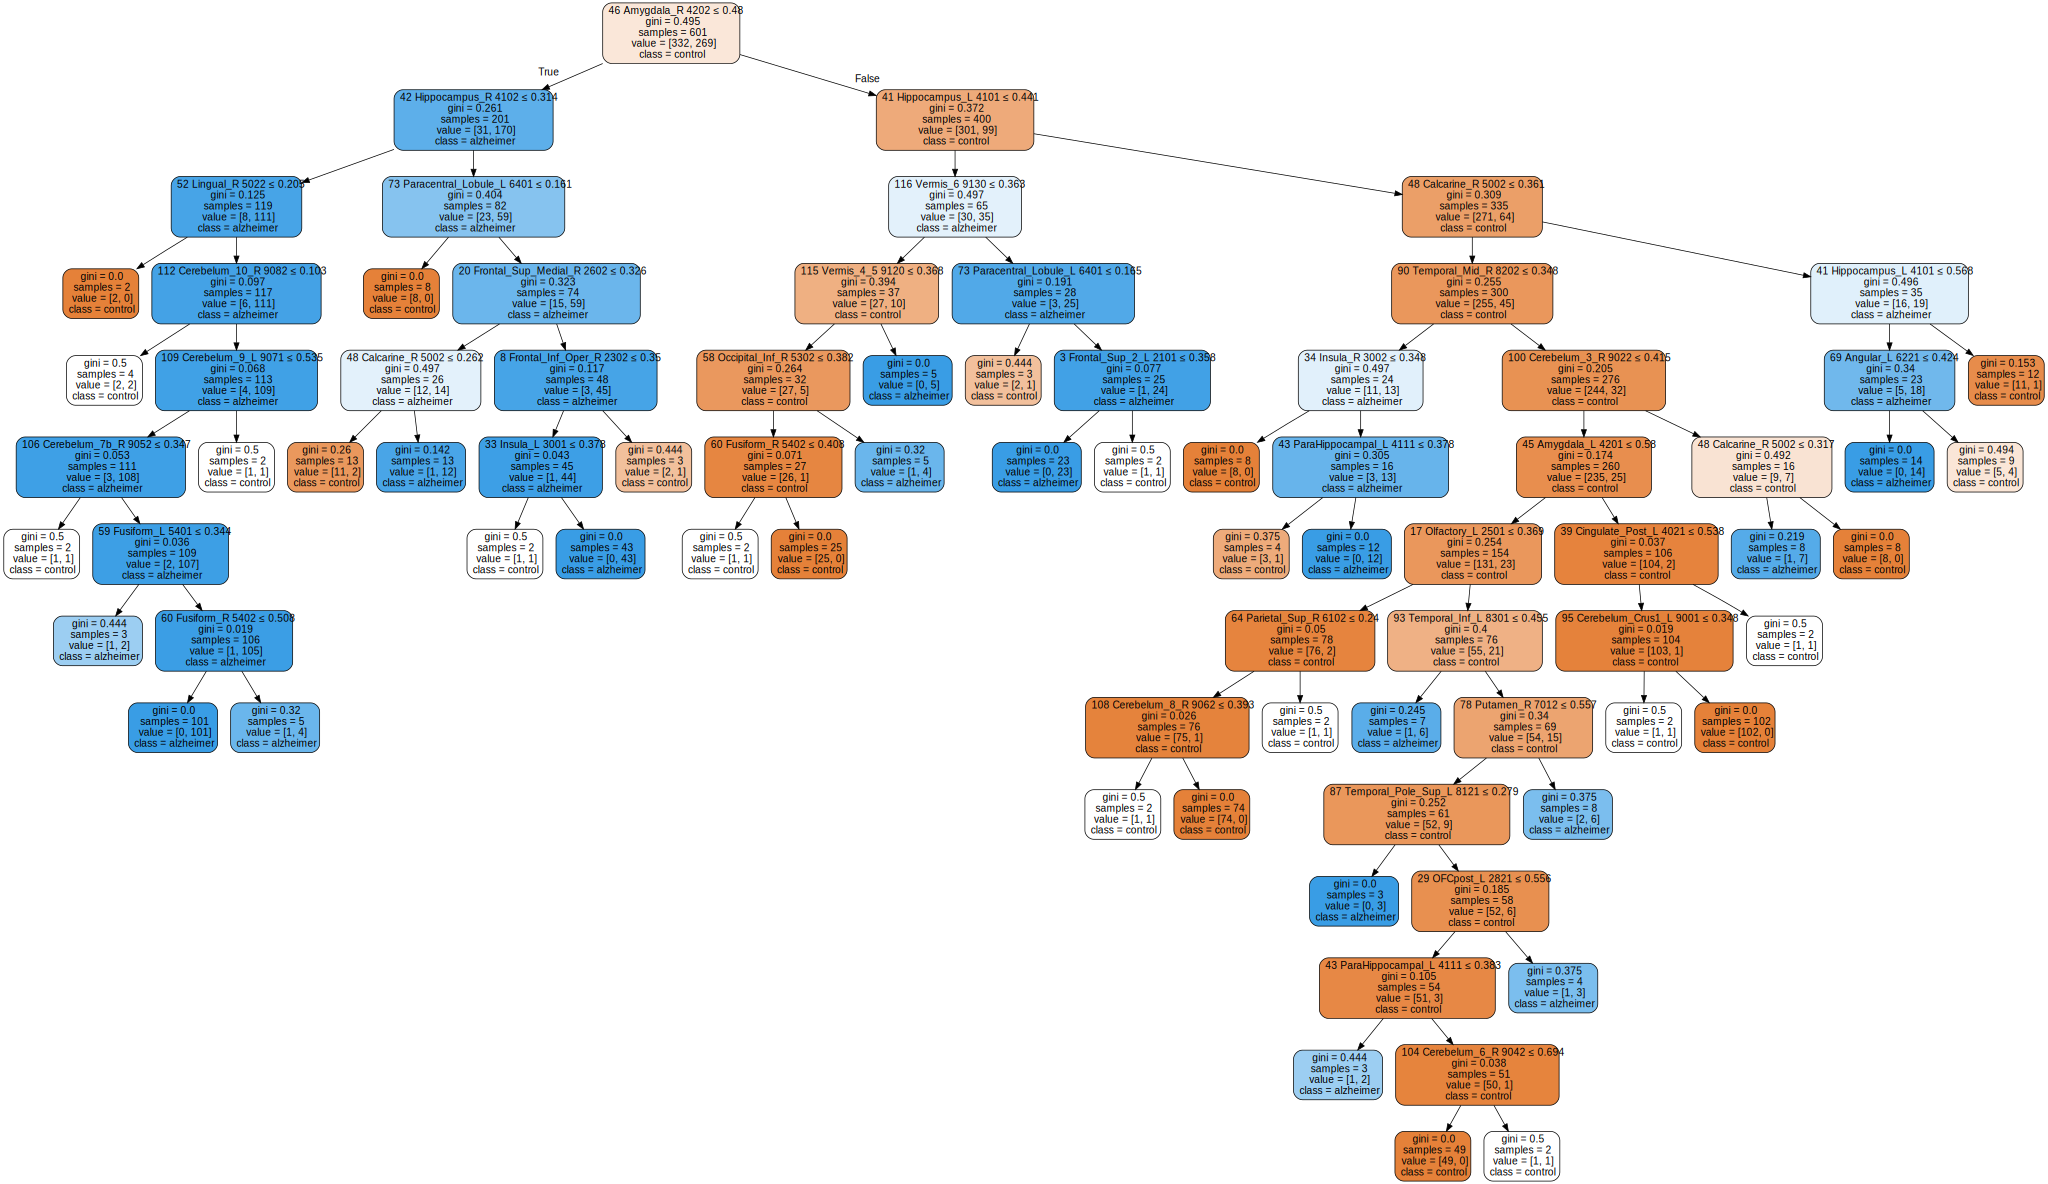

In [12]:
import graphviz

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

## Tree with noise

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer**

No, we don't have the same tree. The difference starts from the root node. In the case of original data we are splitting according to the feature 46 and in the second case we are splitting along the feature 87

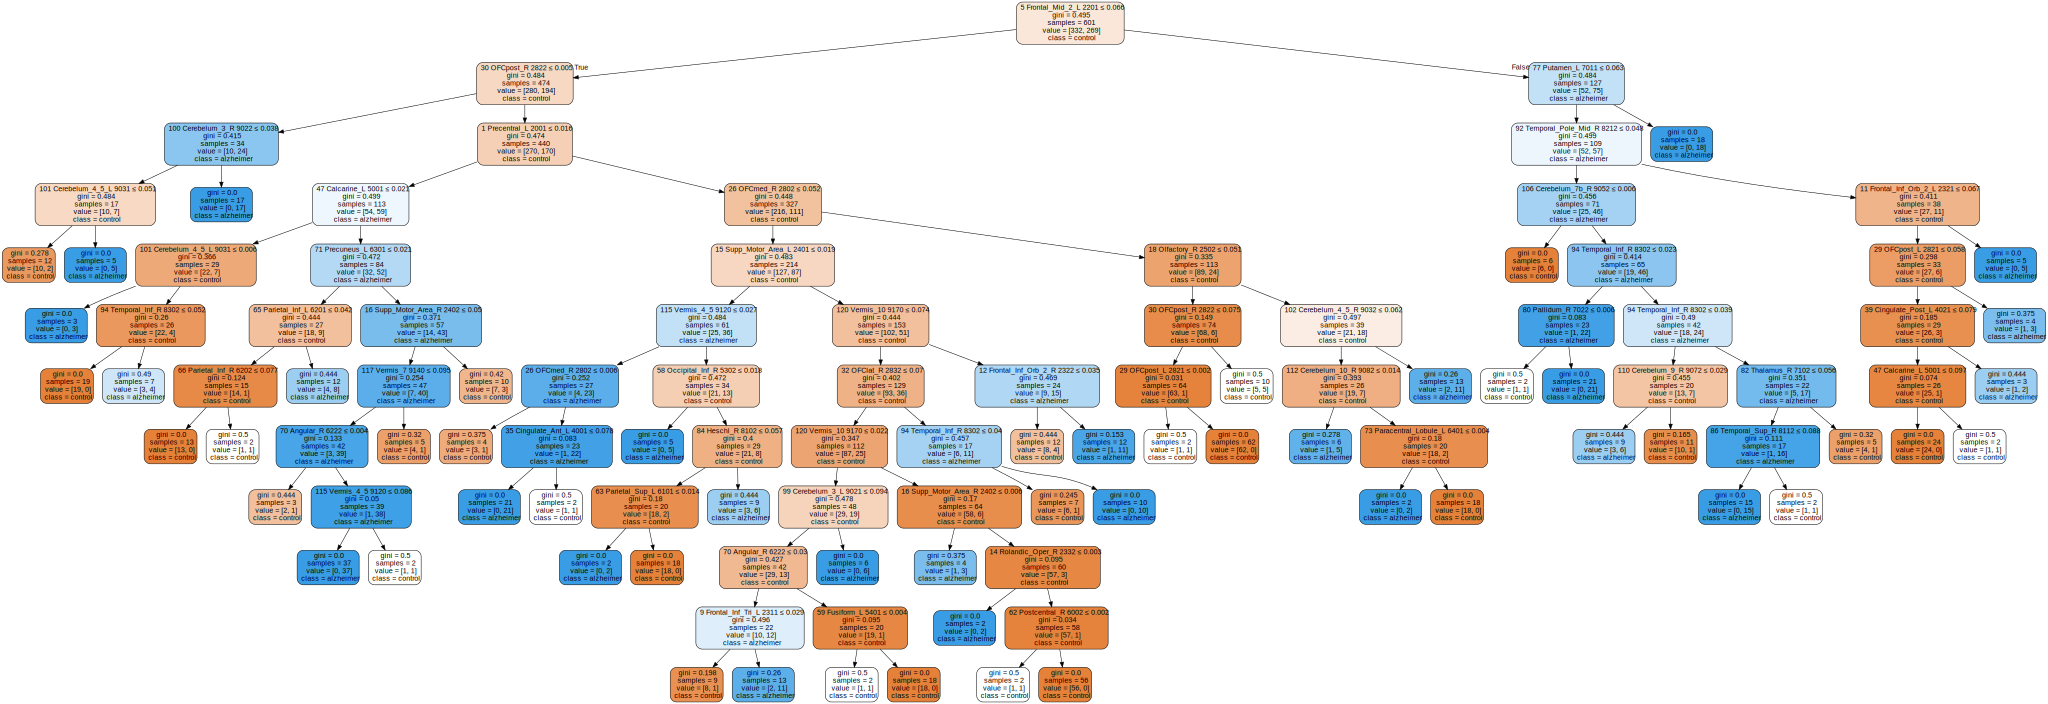

In [13]:
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Hyperparameters selection using GridSearch

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way.

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer**

- Yes, I find the same optimal hyperparameter for min_samples_split (=2) and a close one for the min_samples_leaf (=16)

- Yes I would use F1 score since it works well in binary classification task

In [14]:
Tree = DecisionTreeClassifier()
p_grid_tree = {"min_samples_split":[i for i in range (2,10)],"min_samples_leaf" : [i for i in range(10,18)]}
grid_tree = GridSearchCV(estimator=Tree,param_grid=p_grid_tree,cv=5)
grid_tree.fit(X_train,y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7586914600550964
Best params: {'min_samples_leaf': 16, 'min_samples_split': 2}
Tree test score : 0.8079470198675497


In [15]:
## Changing metric to f1 score
Tree = DecisionTreeClassifier()
p_grid_tree = {"min_samples_split":[i for i in range (2,10)],"min_samples_leaf" : [i for i in range(10,18)]}
grid_tree = GridSearchCV(estimator=Tree,param_grid=p_grid_tree,scoring='f1' , cv=5)
grid_tree.fit(X_train,y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.716084352708027
Best params: {'min_samples_leaf': 14, 'min_samples_split': 2}
Tree test score : 0.7441860465116278


## Visualization of the tree

Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library.

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer**
No the tree is not exactly the same as before. However, when comapring the obtained trees so far we noitice that there are 3 main features that are almost always present near the root which are : feature number 42 "Hippocampus_R" and feature number 41 "Hippocampus_L" and 45 : "Amygdala_L".

In my opinion this means that these two features are very important in this classification task and they are crucial in knowing whether the patient has Alzheimer or not

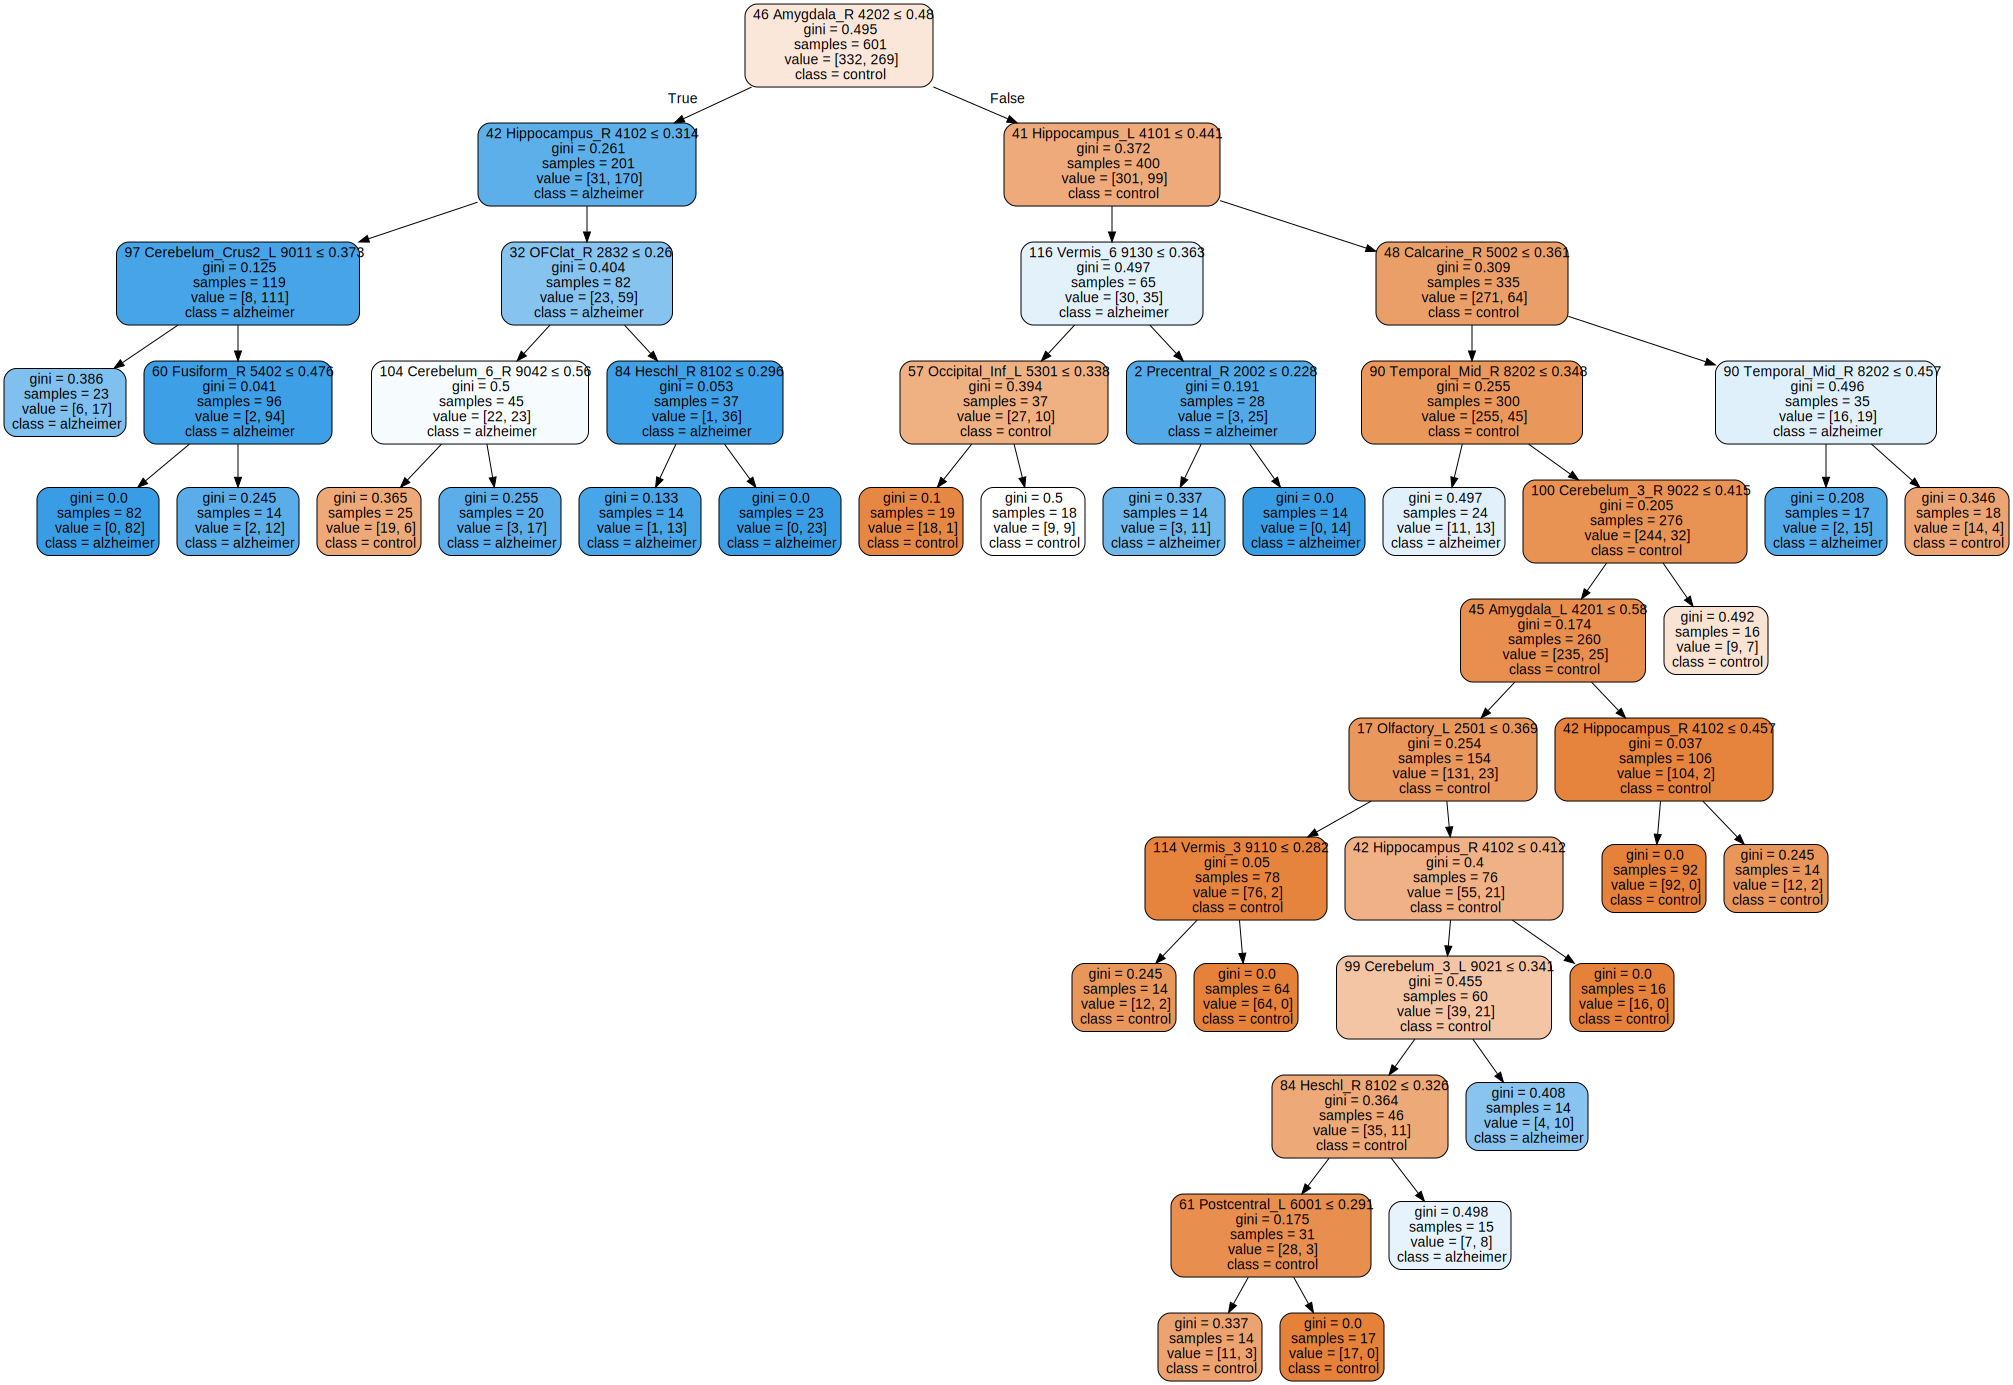

In [16]:
dot_data = tree.export_graphviz(grid_tree.best_estimator_, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Using Bagging

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'.

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ?

**Answer**

When we use the original data we get a good performance : we get a high training score and a high test score (around 0.80 both) this is a good indicator of neither underfitting nor overfitting.

However when we use the noisy version, we get less preformant results in both training and testing with the given hyperparameters. This means that even with bagging our model is still sensitive to noise

In [17]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging,cv=5)
grid_bagging.fit(X_train,y_train.reshape((y_train.shape[0],)) )
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.reshape((y_test.shape[0],))) )

Best Validation Score: 0.8086088154269973
Best params: {'n_estimators': 15}
Bagging test score : 0.8013245033112583


In [18]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging,cv=5)
grid_bagging.fit(X_train_temp,y_train.reshape((y_train.shape[0],)) )
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.reshape((y_test.shape[0],))) )

Best Validation Score: 0.5641322314049587
Best params: {'n_estimators': 20}
Bagging test score : 0.5562913907284768


# Random Forests

The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [19]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1", cv=5)
grid_RF.fit(X_train, y_train.squeeze())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test.squeeze()))

Best Validation Score: 0.8047650652035376
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.7936507936507936


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging.

In [20]:
# Random Forest on noisy data
RF=RandomForestClassifier(n_estimators=grid_RF.best_params_["n_estimators"],min_samples_leaf=grid_RF.best_params_["min_samples_leaf"],max_features=grid_RF.best_params_["max_features"],random_state=0)
RF.fit(X_train_temp,y_train.ravel())
print("Random Forest train score :",RF.score(X_train_temp,y_train.squeeze()))
print("Random Forest test score :",RF.score(X_test,y_test.squeeze()))

Random Forest train score : 1.0
Random Forest test score : 0.5562913907284768


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.089454)
2. feature 44 representing 45 Amygdala_L 4201
 (0.076285)
3. feature 40 representing 41 Hippocampus_L 4101
 (0.043547)
4. feature 43 representing 44 ParaHippocampal_R 4112
 (0.040923)
5. feature 93 representing 94 Temporal_Inf_R 8302
 (0.037989)
6. feature 92 representing 93 Temporal_Inf_L 8301
 (0.034526)
7. feature 59 representing 60 Fusiform_R 5402
 (0.032778)
8. feature 41 representing 42 Hippocampus_R 4102
 (0.032156)
9. feature 69 representing 70 Angular_R 6222
 (0.016868)
10. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.016329)


<ipython-input-21-53ceafd34eab>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train,y_train)


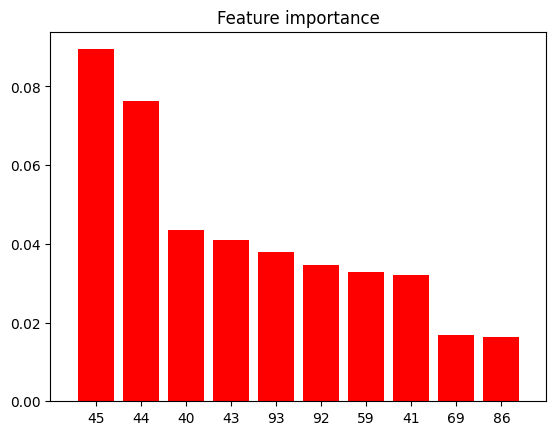

In [21]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense.

**Answer**
The most important features are the gray matter density in these regions : 46- Amygdala_R , 45-Amygdala_L ,42-Hippocampus_L and 42-Hippocampus_R.

Indeed the given articals describes that these regions are strong indicators of presence of Alzheimer.

We can also inspect the data using only pairs of the most important features

classifier 0 has accuracy in train 0.8868552412645591 and test  0.7218543046357616
classifier 1 has accuracy in train 0.9434276206322796 and test  0.7748344370860927
classifier 2 has accuracy in train 0.9201331114808652 and test  0.7284768211920529
classifier 3 has accuracy in train 0.9434276206322796 and test  0.7748344370860927
classifier 4 has accuracy in train 0.9201331114808652 and test  0.7284768211920529
classifier 5 has accuracy in train 0.9450915141430949 and test  0.7549668874172185


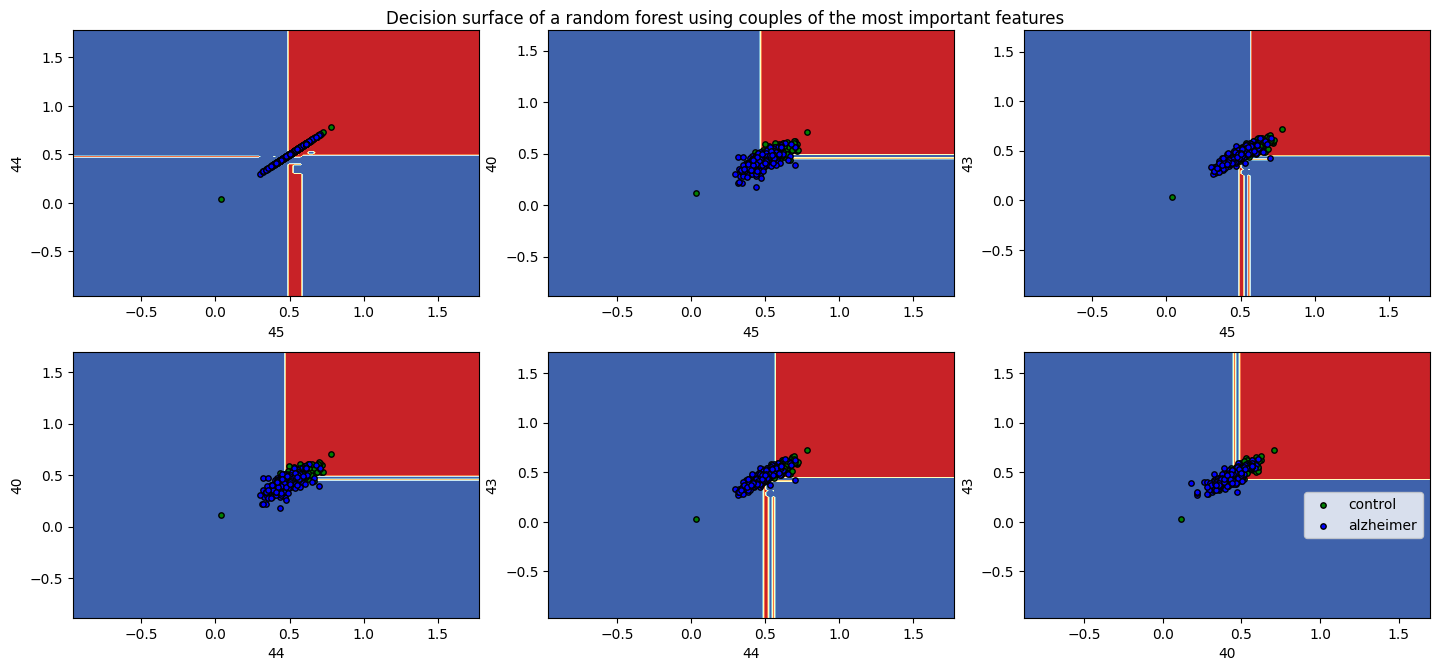

In [22]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair.ravel())
    print(f"classifier {pairidx} has accuracy in train {clf.score(X_train[:,pair],y_train)} and test  {clf.score(X_test[:,pair],y_test)}")
    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "gb"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                     edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer**

The best couple seems to be the the second and the fourth aka [indices[0],indices[2]] = [45,40] and  [indices[1],indices[2]] = [44,40] These two gave the highest train and test scores and gave the same decision boundary

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**Answer**

After using the two other Atlases and comparing the obtained resutls, We noitce that the best test scores are achieved with HAMMERS' Atlas. However the other two achieve comparable performance. Overall, when observing the ranking of the Influence of regions of interst according to each model, we conclude that the Amygdala and Hippocampus are the most influencial commun regions in deciding whether the patient has Alzheimer or not. Based on these results, we can conclude that these regions can be defined as biomarkerers of Alzheimer's disease.

After checking the given research papers, we confirm the importance of these two regions in the classification.

# Testing with different Atlas

## AICHA

### Choosing data

In [23]:
# Choose Atlas (here AICHA)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


In [24]:
# Create training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(f"nomber of training sample {X_train.shape[0]}, test samples {X_test.shape[0]}")

nomber of training sample 601, test samples 151


### Decision Tree

In [25]:
Tree = DecisionTreeClassifier()
p_grid_tree = {"min_samples_split":[i for i in range (2,10)],"min_samples_leaf" : [i for i in range(10,18)]}
grid_tree = GridSearchCV(estimator=Tree,param_grid=p_grid_tree,cv=5)
grid_tree.fit(X_train,y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7687052341597796
Best params: {'min_samples_leaf': 14, 'min_samples_split': 7}
Tree test score : 0.7218543046357616


### Decision Tree with Bgging

In [26]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging,cv=5)
grid_bagging.fit(X_train,y_train.reshape((y_train.shape[0],)) )
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.reshape((y_test.shape[0],))) )

Best Validation Score: 0.7853719008264463
Best params: {'n_estimators': 15}
Bagging test score : 0.7417218543046358


### Random Forest

In [27]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1", cv=5)
grid_RF.fit(X_train, y_train.squeeze())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test.squeeze()))

Best Validation Score: 0.7364354796732833
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 30}
Random Forest test score : 0.7419354838709676


<ipython-input-28-53ceafd34eab>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train,y_train)


Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.064126)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.029397)
3. feature 188 representing 189	N_Thalamus-6	190
 (0.024530)
4. feature 172 representing 173	N_Amygdala-1	174
 (0.022101)
5. feature 173 representing 174	N_Caudate-1	175
 (0.020571)
6. feature 186 representing 187	N_Thalamus-4	188
 (0.020281)
7. feature 170 representing 171	G_Fusiform-6	172
 (0.019890)
8. feature 74 representing 75	G_Insula-anterior-3	76
 (0.018383)
9. feature 180 representing 181	N_Pallidum-1	182
 (0.017292)
10. feature 189 representing 190	N_Thalamus-7	191
 (0.016822)


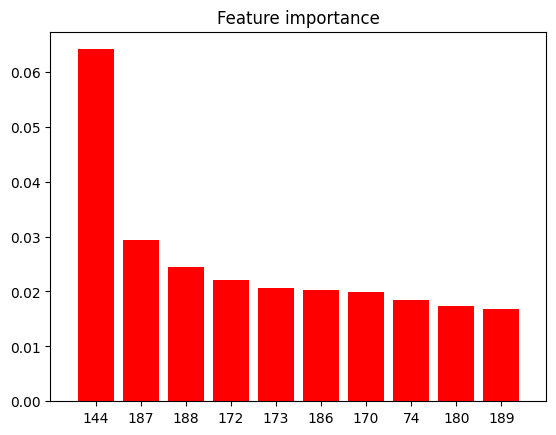

In [28]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

classifier 0 has accuracy in train 0.8935108153078203 and test  0.7086092715231788
classifier 1 has accuracy in train 0.8752079866888519 and test  0.7483443708609272
classifier 2 has accuracy in train 0.8968386023294509 and test  0.6821192052980133
classifier 3 has accuracy in train 0.8885191347753744 and test  0.6622516556291391
classifier 4 has accuracy in train 0.8901830282861897 and test  0.6688741721854304
classifier 5 has accuracy in train 0.908485856905158 and test  0.6754966887417219


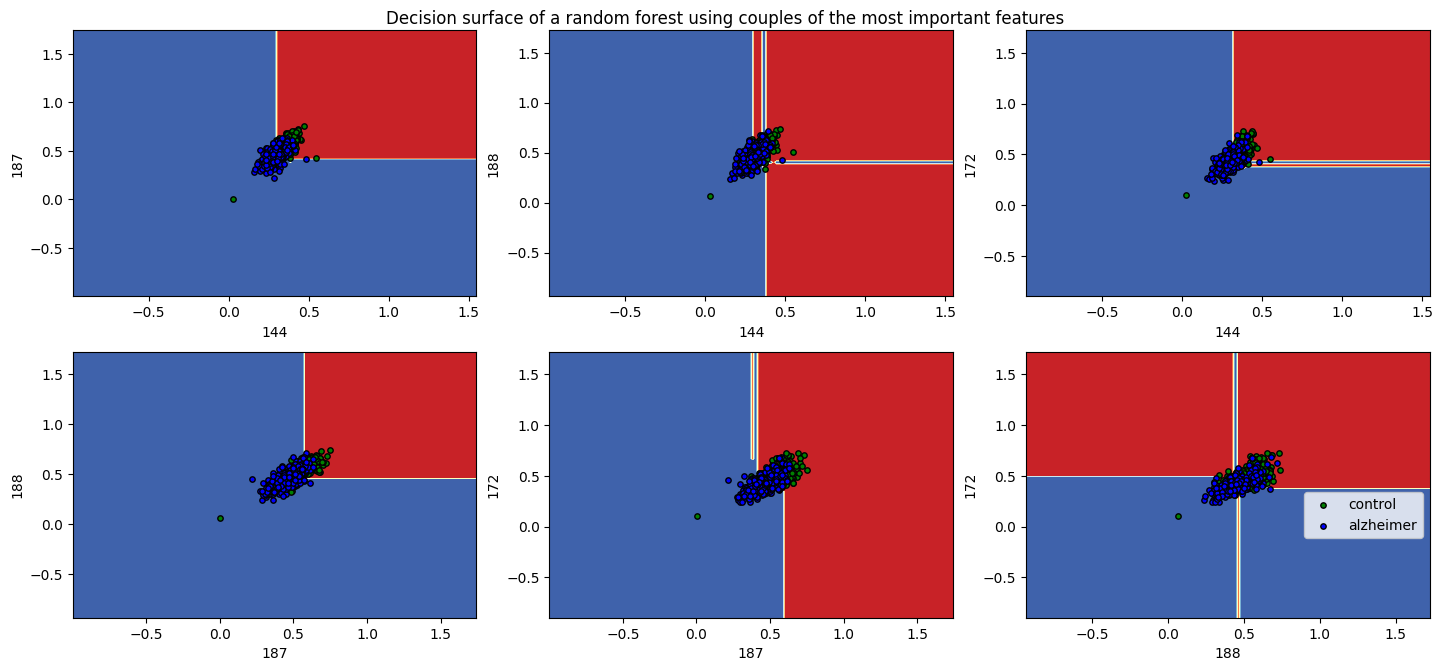

In [29]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair.ravel())
    print(f"classifier {pairidx} has accuracy in train {clf.score(X_train[:,pair],y_train)} and test  {clf.score(X_test[:,pair],y_test)}")
    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "gb"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                     edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

## HAMMERS

### Choosing data

In [30]:
# Choose Atlas (here AICHA)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


In [31]:
# Create training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(f"nomber of training sample {X_train.shape[0]}, test samples {X_test.shape[0]}")

nomber of training sample 601, test samples 151


### Decision Tree

In [32]:
Tree = DecisionTreeClassifier()
p_grid_tree = {"min_samples_split":[i for i in range (2,10)],"min_samples_leaf" : [i for i in range(10,18)]}
grid_tree = GridSearchCV(estimator=Tree,param_grid=p_grid_tree,cv=5)
grid_tree.fit(X_train,y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7619559228650139
Best params: {'min_samples_leaf': 17, 'min_samples_split': 9}
Tree test score : 0.8145695364238411


### Decision Tree with Bgging

In [33]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging,cv=5)
grid_bagging.fit(X_train,y_train.reshape((y_train.shape[0],)) )
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.reshape((y_test.shape[0],))) )

Best Validation Score: 0.815275482093664
Best params: {'n_estimators': 15}
Bagging test score : 0.8145695364238411


### Random Forest

In [34]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="f1", cv=5)
grid_RF.fit(X_train, y_train.squeeze())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test.squeeze()))

Best Validation Score: 0.8023712484979901
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 30}
Random Forest test score : 0.7903225806451613


Feature ranking:
1. feature 3 representing Right Amygdala                         (0.109515)
2. feature 2 representing Left Amygdala                          (0.082363)
3. feature 0 representing Left Hippocampus                       (0.081501)
4. feature 1 representing Right Hippocampus                      (0.058756)
5. feature 4 representing Left Anterior Medial Temporal Lobe     (0.035131)
6. feature 46 representing Left Lateral Temporal Ventricle        (0.034180)
7. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.033969)
8. feature 5 representing Right Anterior Medial Temporal Lobe    (0.031554)
9. feature 12 representing Left Inferior Middle Temporal Gyri     (0.028950)
10. feature 47 representing Right Lateral Temporal Ventricle       (0.023536)


<ipython-input-35-53ceafd34eab>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train,y_train)


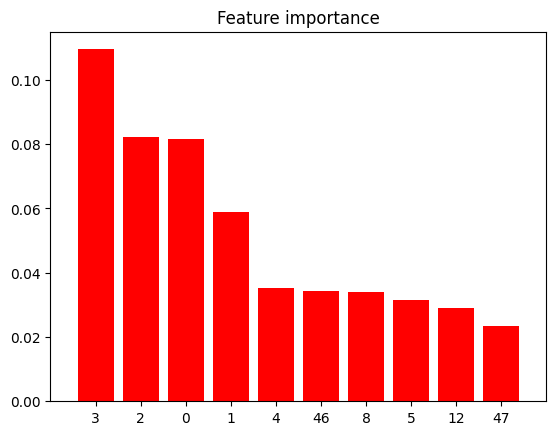

In [35]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

classifier 0 has accuracy in train 0.8635607321131448 and test  0.8145695364238411
classifier 1 has accuracy in train 0.8569051580698835 and test  0.7748344370860927
classifier 2 has accuracy in train 0.831946755407654 and test  0.7947019867549668
classifier 3 has accuracy in train 0.8618968386023295 and test  0.7483443708609272
classifier 4 has accuracy in train 0.8369384359400999 and test  0.7615894039735099
classifier 5 has accuracy in train 0.8469217970049917 and test  0.7615894039735099


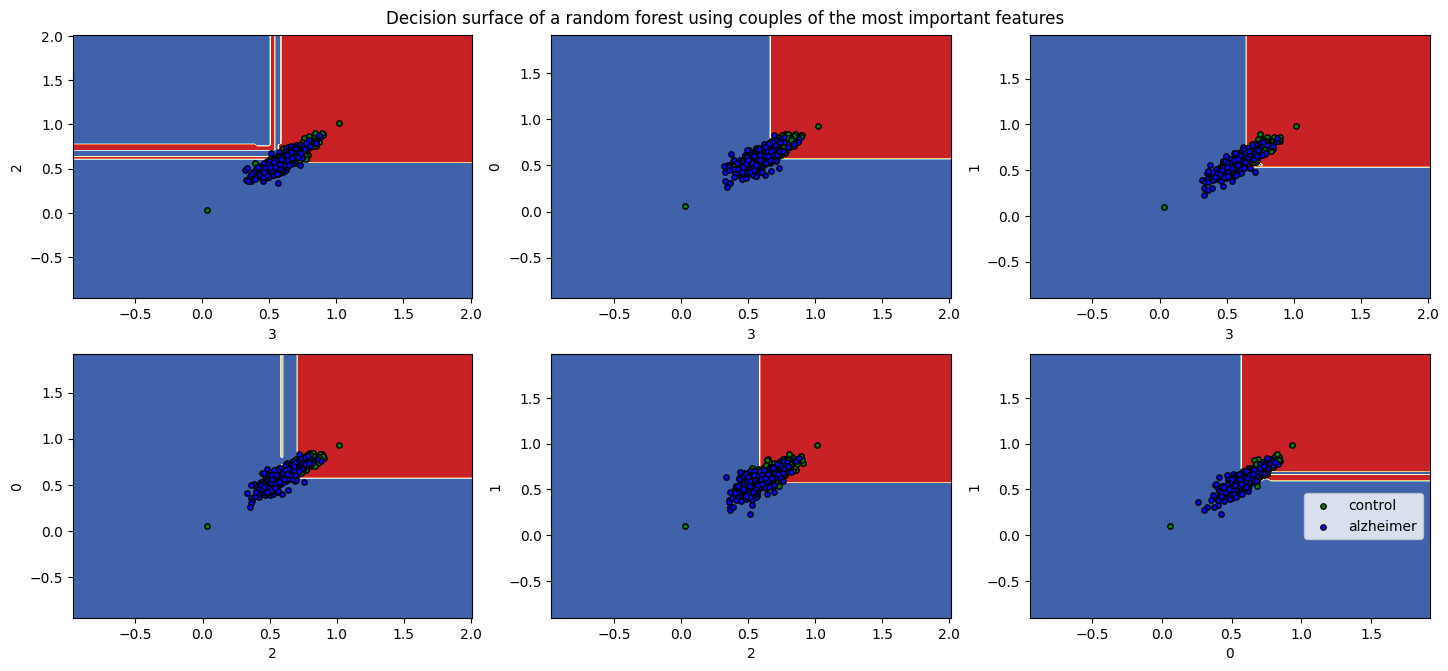

In [36]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair.ravel())
    print(f"classifier {pairidx} has accuracy in train {clf.score(X_train[:,pair],y_train)} and test  {clf.score(X_test[:,pair],y_test)}")
    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "gb"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                     edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()